In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWihsd035KiWz1fvNh6czWYAqSgRIMn1qwFHg-ae06o91smN0LdZssI
Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm
import pandas as pd 
import numpy as np
import re
from sklearn.model_selection import train_test_split

# Data preprocessing

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/GP_Chatbot_Dataset/daily_dialoge/data.pickle')
# all_filenames = ["/content/drive/MyDrive/GP_Chatbot_Dataset/neg.csv" , "/content/drive/MyDrive/GP_Chatbot_Dataset/pos.csv"]
# df = pd.concat([pd.read_csv(f) for f in all_filenames ]) [['sentence','class']]
# df = shuffle(df)

# for i in tqdm(range(df.shape[0])):
#     df.iloc[i]['sentence'] = df.iloc[i]['sentence'].replace('_comma_',',')

In [ ]:
df.head()

,sentence,action,emotion
0,The kitchen stinks .,3,2
1,I'll throw out the garbage .,4,0
2,\n,\n,\n
3,"So Dick , how about getting some coffee for to...",3,4
4,Coffee ? I don ’ t honestly like that kind of...,4,2


#### combine classes

In [ ]:
data = df
for i in tqdm(range(data.shape[0])):
    intent = data['emotion'].iloc[i]
    if intent == '0':
        data['emotion'].iloc[i] = 'neutral'
    elif intent == '1':
        data['emotion'].iloc[i] = 'angry'
    elif intent == '2':
        data['emotion'].iloc[i] = 'disgust'
    elif intent == '3':
        data['emotion'].iloc[i] = 'fear'
    elif intent == '4':
        data['emotion'].iloc[i] = 'happy'
    elif intent == '5':
        data['emotion'].iloc[i] = 'sad'
    elif intent == '6':
        data['emotion'].iloc[i]= 'surprise'
    elif intent == '\n':
        data['emotion'].iloc[i]= 'end'    
data = data[data['emotion'] != 'disgust'] 
data = data[data['emotion'] != 'end'] 

# for i in tqdm(range(data.shape[0])):
#     intent = data['class'].iloc[i]
#     if((intent == 'afraid') or (intent == 'terrified') or (intent == 'anxious')):
#         data['class'].iloc[i] = 'afraid'
  

# data = data[data['class'] != 'grateful'] 
# data = data[data['class'] != 'devastated']  
# data = data[data['class'] != 'content'] 
    
# data = data[data['class'] != 'anxious']    
# data = data[data['class'] != 'impressed']
# data = data[data['class'] != 'surprised']
# data = data[data['class'] != 'apprehensive']

# data = data[data['class'] != 'jealous'] 
# data = data[data['class'] != 'embarrassed'] 
# data = data[data['class'] != 'guilty']
# data = data[data['class'] != 'ashamed'] 

# data = data[data['class'] != 'anticipating'] 
# data = data[data['class'] != 'confident']  
# data = data[data['class'] != 'prepared']  
# data = data[data['class'] != 'trusting']  
# data = data[data['class'] != 'hopeful']
# data = data[data['class'] != 'caring']    


 41%|████      | 47186/116085 [00:27<00:39, 1762.64it/s]

In [ ]:
print(len(data)) 
data.head()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['emotion'], test_size=0.1, random_state=37)

In [ ]:
import numpy as np
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(data['emotion'])
train_labels = lb.transform(y_train)
test_labels = lb.transform(y_test)

print(train_labels)
train_data = data['sentence']
print(train_data.shape)
print(train_labels.shape)

In [ ]:
classes = list(set(data['emotion']))
classes.sort()
num_classes = len(classes)
print('num_classes', num_classes)
print(classes)

# MODEL

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Concatenate
# from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

!pip install mtranslate
from mtranslate import translate

pd.set_option('display.max_colwidth', None)


In [ ]:
# Basic packages
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent


# Used functions

In [ ]:
def eval_metric(model, history, metric_name,model_nam):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name+' ' +model_nam)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results  

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch    
          

In [ ]:
%%time
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

CPU times: user 16.8 s, sys: 1.96 s, total: 18.8 s
Wall time: 18 s


# Reducing the network’s capacity

In [ ]:
def get_reduced_model(module_url):
    model = tf.keras.Sequential([
    
        hub.KerasLayer(module_url, input_shape=[],dtype=tf.string, trainable=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return(model)
Reduced_model = get_reduced_model(module_url) 
Reduced_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
Reduced_history = Reduced_model.fit(X_train
                       ,train_labels
                       ,validation_split=0.30
                       ,epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , verbose=0)   

Minimum validation loss reached in epoch 20


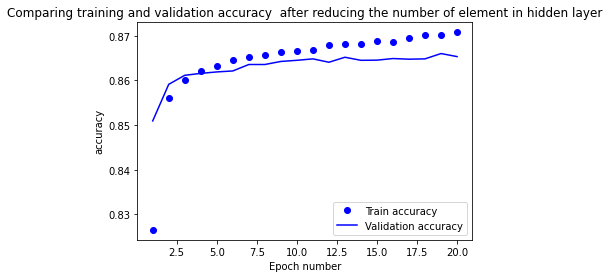

In [ ]:
reduced_min = optimal_epoch(Reduced_history)
eval_metric(Reduced_model, Reduced_history, 'accuracy', ' after reducing the number of element in hidden layer')

# Adding dropout layers
#### A Dropout layer will randomly set output features of a layer to zero.

In [ ]:
def get_Dropout_model(module_url):
    model = tf.keras.Sequential([
    
        hub.KerasLayer(module_url, input_shape=[],dtype=tf.string, trainable=False),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return(model)
drop_model = get_Dropout_model(module_url) 
drop_model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
drop_history = drop_model.fit(X_train
                       ,train_labels
                       ,validation_split=0.30
                       ,epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , verbose=0)   

Minimum validation loss reached in epoch 60


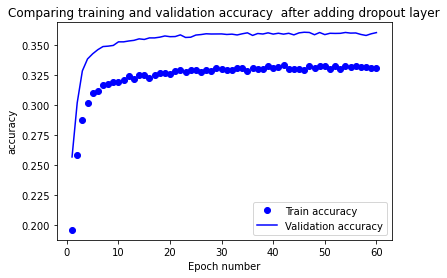

In [ ]:
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'accuracy', ' after adding dropout layer')

# Applying regularization
#### try with L2 regularization.

In [ ]:
def get_reg_model(module_url):
    model = tf.keras.Sequential([
        hub.KerasLayer(module_url, input_shape=[],dtype=tf.string, trainable=False),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return(model)
reg_model = get_reg_model(module_url) 
reg_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
reg_history = reg_model.fit(X_train
                       ,train_labels
                       ,validation_split=0.30
                       ,epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , verbose=0)   


Minimum validation loss reached in epoch 24


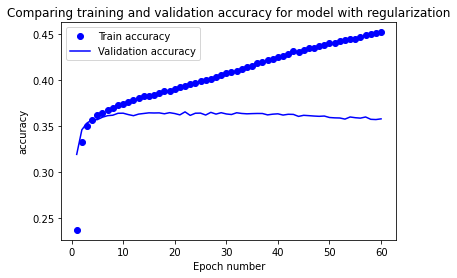

In [ ]:
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model, reg_history, 'accuracy', 'for model with regularization')

In [ ]:
reg_results = test_model(reg_model, X_train, train_labels, X_test, test_labels, reg_min)

307/307 [==============================] - 12s 38ms/step - loss: 2.0202 - accuracy: 0.3541

Test accuracy: 35.41%


In [ ]:

reduced_results = test_model(Reduced_model, X_train, train_labels, X_test, test_labels, reduced_min)

# drop_results = test_model(drop_model, X_train, train_labels, X_test, test_labels, drop_min)

321/321 [==============================] - 12s 39ms/step - loss: 0.3683 - accuracy: 0.8707

Test accuracy: 87.07%


In [ ]:
Reduced_model.save('/content/drive/MyDrive/GP_Chatbot_Dataset/Ddialoge_models/USE_reduced_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP_Chatbot_Dataset/Ddialoge_models/USE_reduced_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GP_Chatbot_Dataset/Ddialoge_models/USE_reduced_model/assets


In [ ]:
loaded = models.load_model('/content/drive/MyDrive/GP_Chatbot_Dataset/Ddialoge_models/USE_reduced_model')

In [ ]:
loaded_results = test_model(loaded, X_train, train_labels, X_test, test_labels, 20)

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/GP_Chatbot_Dataset/models/USE_moodClassification.h5' , custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
import operator
input_msg = "ماما تعبانه"
input_msg = translate(input_msg ,'en')
print(input_msg)
test_pred = Reduced_model.predict([str(input_msg)])
print(test_pred)

max_index, max_value = max(enumerate(test_pred[0]), key=operator.itemgetter(1))
print(max_index)
if classes[max_index] == 'neutral':
    test_pred[0].tolist().pop(max_index)
    classes_new = classes
    classes_new.pop(max_index)
    max_index, max_value = max(enumerate(test_pred[0]), key=operator.itemgetter(1))
    print(max_index)


print('class: ',classes[max_index])

Mama is tired
[[6.9806853e-04 1.5711004e-03 2.0009656e-02 9.6299422e-01 1.3733068e-02
  9.9391595e-04]]
3
class:  sad
